## Images of the Dataset
Downloading of X-ray images of GDXray that are used in these examples.

In [ ]:
!mkdir ~/GDXray
!mkdir ~/GDXray/Baggages

!wget https://www.dropbox.com/s/swysmbjjuhnwpq6/B0044.zip
!unzip -oq B0044.zip  # Force to overwrite facilitates running the notebook without interactive actions
!rm B0044.zip
!rsync -av B0044 ~/GDXray/Baggages/

print('Images of series B0044 of GDXray have been downloaded and stored in directory GDXray/.')


In [ ]:
# Load calibrated projection matrices
import scipy.io as sio
!wget https://www.dropbox.com/s/es2k1qx1v6qle37/Pmatrices.mat
data = sio.loadmat('Pmatrices.mat')

--2021-09-11 10:45:45--  https://www.dropbox.com/s/es2k1qx1v6qle37/Pmatrices.mat
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/es2k1qx1v6qle37/Pmatrices.mat [following]
--2021-09-11 10:45:46--  https://www.dropbox.com/s/raw/es2k1qx1v6qle37/Pmatrices.mat
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc069bcecd7cb96fe081e7d5235.dl.dropboxusercontent.com/cd/0/inline/BV8ncatvPMlqdIiGyDjbJZ0pPzpgJom97YB1z_SfHL8y-jLaIACB66CfpXdfNc8cwygyXL7x9e8xSasf2J-8vIEG4OPWQZ8PkJfE0dMP4HSn6p4YDHPxnNT1ctLvM9MJ7gA7-d6sENiLkh9sZ8Xb2MDc/file# [following]
--2021-09-11 10:45:46--  https://ucc069bcecd7cb96fe081e7d5235.dl.dropboxusercontent.com/cd/0/inline/BV8ncatvPMlqdIiGyDjbJZ0pPzpgJom97YB1z_SfHL8y-jLaIACB66CfpXdfNc8cwygyXL7x9e8xSasf2J-8

## Installation of Libraries

In [ ]:


def plot_epipolar_line(mat_f, m, ax, line_color='r'):
    """
    This method plot an epipolar line into an open figure.

    Args:
        mat_f: numpy array with the fundamental matrix
        m: numpy array with a image point (2D)
        ax: a matplotlib figure axe
        line_color: an string indicating the line color
    
    Returns:
        ax: the figure axe

    """
    if m.shape[-1] == 2:
        m = np.hstack([m, np.ones((m.shape[0], 1))])

    ell = np.dot(mat_f, m)
    ell = ell / ell[-1]
    ax_lim = ax.axis()
    x = np.asarray(ax_lim[0:2])
    a = ell[0]
    b = ell[1]
    c = ell[2]

    y = -(c + a * x) / b

    ax.plot(x, y, line_color)
    ax.axis('off')

    return ax

def estimate_fundamental_matrix(mat_a, mat_b, method='pseudo'):
    """
    This method computes the 3x3 fundamental matrix from 3x4 projection matrices A and B according methods defined in
    method parameter. We refer the reader to [1] for more details about this implementation.

    Args:
        mat_a: numpy array with projection matrix of view 1
        mat_b: numpy array with projection matrix of view 2
        method: a string defining computation method. If no method is given,
            'pseudo' will be assumed as default.
            'tensor' : uses bifocal tensors with canonic matrix
            'tensor0': uses bifocal tensors without canonic matrix
            'pseudo' : uses pseudoinverse matrix of A (default)

    Returns:
        mat_f: the 3x3 fundamental matrix.

    [1] R. Hartley and A. Zisserman. Multiple View Geometry in Computer Vision.
    Cambridge University Press, 2000.
    """

    if method.lower() == 'tensor':
        mat_h = np.vstack([mat_a, np.random.rand(4)])

        while np.abs(np.linalg.det(mat_h)) < 0.001:
            mat_h = np.vstack([mat_a, np.random.rand(4)])

        mat_bs = np.dot(mat_b, np.linalg.inv(mat_h))
        b = np.vstack([mat_bs, mat_bs])

        mat_f = np.zeros((3, 3))

        for i in range(3):
            for j in range(3):
                mat_f[i, j] = b[i + 1, j] * b[i + 2, 3] - b[i + 2, j] * b[
                    i + 1, 3]

    elif method.lower() == 'tensor0':
        # TODO: Verificar con Domingo
        mat_f = np.zeros((3, 3))

        for i in range(3):
            sb = mat_b.copy()
            sb = np.delete(sb, i, 0)

            for j in range(3):
                sa = mat_a.copy()
                sa = np.delete(sa, j, 0)

                mat_f[i][j] = (-1) ** (i + j) * np.linalg.det(
                    np.vstack([sa, sb]))

    else:
        # Find mat_c1 as the null space of the projection matrix using SVD factorization of mat_a. The null vector is 
        # the last row in the matrix V.T . See numpy documentation for more details.

        _, _, mat_v = np.linalg.svd(mat_a)
        mat_c1 = mat_v[-1, :].reshape(-1, 1)
        mat_u = skew_symmetric(mat_b, mat_c1)

        # Compute the fundamental matrix
        mat_f = np.asmatrix(mat_u) * np.asmatrix(mat_b) * np.asmatrix(
            np.linalg.pinv(mat_a))
        mat_f = np.array(mat_f)

    mat_f = np.array(mat_f / np.linalg.norm(mat_f)[0])  # Normalize as F / norm(F)

    return mat_f

def skew_symmetric(mat, null_space):
    """
    Compute the skew-symmetric matrix.

    :param mat: numpy array with a projection matrix (3x4)
    :param null_space: an array with the null space
    :return: an array with the skew-symmetric matrix.

    """
    # epipole in second view
    e2 = np.dot(mat, null_space)

    # The vector e2 as Skew-symmetric matrix
    mat_u = np.array(
        [
            [0, -e2[2], e2[1]],
            [e2[2], 0, -e2[0]],
            [-e2[1], e2[0], 0]
        ]
    )

    return mat_u


def num2fixstr(x,d):
  # example num2fixstr(2,5) returns '00002'
  # example num2fixstr(19,3) returns '019'
  st = '%0*d' % (d,x)
  return st


# Epipolar geometry with two views
This example shows epipolar lines in two views ($p$ and $q$). We assume that the projection matrices ${\bf P}_p$ and ${\bf P}_q$ are known from a calibration process. The code computes the fundamental matrix. We select manually eight $m_p$ points in view $p$. The code plots the epipolar lines of these points in view $q$.

Projection Matrices:
P1 =  [[-7.96593955e+03 -1.20081318e+03  5.35587150e+00  1.29786479e+06]
 [-2.15860979e+01 -1.28491171e+03 -7.95823608e+03  1.06426593e+06]
 [-1.43537660e-02 -9.99895554e-01  1.68838178e-03  9.64055869e+02]]
P2 =  [[ 7.20498704e+03  3.60365190e+03  5.35587150e+00  1.29786479e+06]
 [-3.76529955e+02  1.22869412e+03 -7.95823608e+03  1.06426593e+06]
 [-2.95333476e-01  9.55392740e-01  1.68838178e-03  9.64055869e+02]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


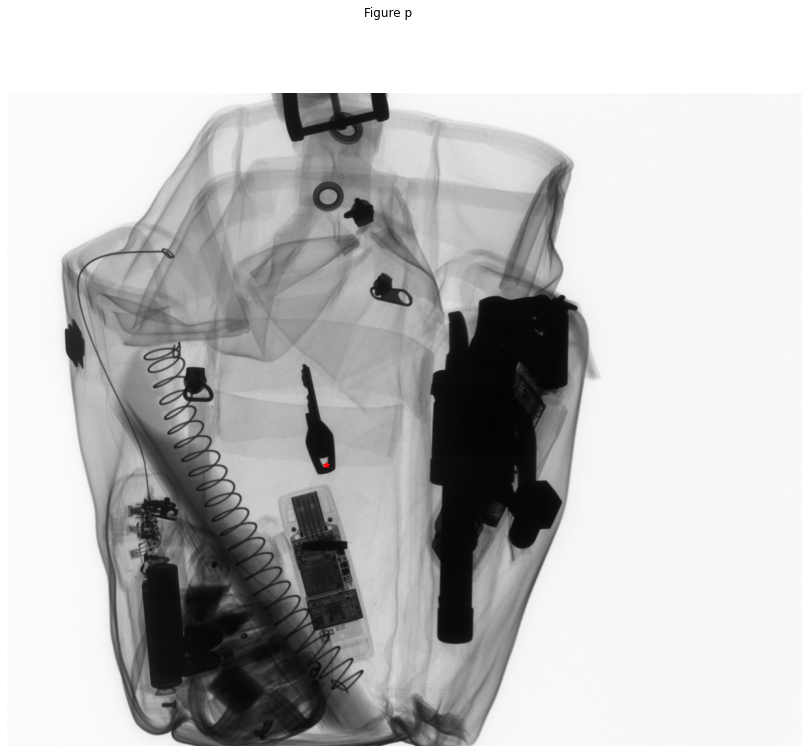

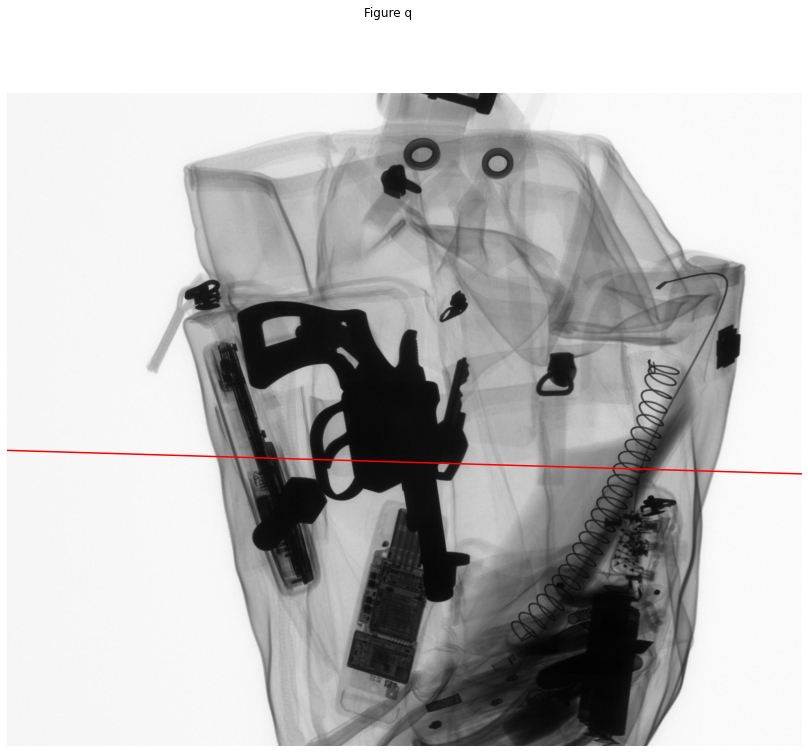

In [ ]:
import numpy as np
import matplotlib.pylab as plt
from cv2 import imread, IMREAD_GRAYSCALE


p, q = (1, 82)  # indices for p and q

# Load projection matrices for views p, q, r
P1 = data['P'][:, :, p]  # Reprojection matrix of view p
P2 = data['P'][:, :, q]  # Reprojection matrix of view q

print('Projection Matrices:')
print('P1 = ',P1)
print('P2 = ',P2)

Ip = imread('B0044/B0044_'+num2fixstr(p,4)+'.png', IMREAD_GRAYSCALE)
Iq = imread('B0044/B0044_'+num2fixstr(q,4)+'.png', IMREAD_GRAYSCALE)



F = estimate_fundamental_matrix(P1, P2, method='pseudo')

colors = 'rcmykwbg'  # Colors for each point-line pair

fig1, ax1 = plt.subplots(1, 1,figsize=(18,12))
fig1.suptitle('Figure p')
ax1.imshow(Ip, cmap='gray')
ax1.axis('off')


fig2, ax2 = plt.subplots(1, 1, subplot_kw=dict(xlim=(0, Ip.shape[1]), ylim=(Iq.shape[0], 1)),figsize=(18,12))
fig2.suptitle('Figure q')
ax2.imshow(Iq, cmap='gray')
ax2.axis('off')
fig2.show()

plt.figure(fig1.number)  # Focus on fig1 and get the mouse locations

# clicked pixel in image 'p'
m = np.ones((3,1))
m[0] = 1080
m[1] = 1256

i = 0
ax1.plot(m[0], m[1], f'{colors[i]}*')  # Plot lines and plot on figures
fig1.canvas.draw()
ax2 = plot_epipolar_line(F, m, line_color=colors[i], ax=ax2)
fig2.canvas.draw()

plt.show()


The code uses two functions of PyXvis: the first one is `estimate_fundamental_matrix` to compute the fundamental matrix and the second one is `plot_epipolar_line` to plot the epipolar lines onto view $q$. The example uses images $p=1$ and $q=82$ of series B0044 of GDXray. In this set of images there are 178 different views (taken by rotating the test object around a quasi vertical axis in $2^0$ between consecutive views). The reader that is interested in other views can change the code in order to define other values for $p$ and $q$.

# Epipolar Geometry with 3 views

Projection Matrices:
P1 =  [[-7.96593955e+03 -1.20081318e+03  5.35587150e+00  1.29786479e+06]
 [-2.15860979e+01 -1.28491171e+03 -7.95823608e+03  1.06426593e+06]
 [-1.43537660e-02 -9.99895554e-01  1.68838178e-03  9.64055869e+02]]
P2 =  [[ 7.91917914e+03  1.47808896e+03  5.35587150e+00  1.29786479e+06]
 [-2.32698237e+01  1.28488232e+03 -7.95823608e+03  1.06426593e+06]
 [-2.05508295e-02  9.99787384e-01  1.68838178e-03  9.64055869e+02]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


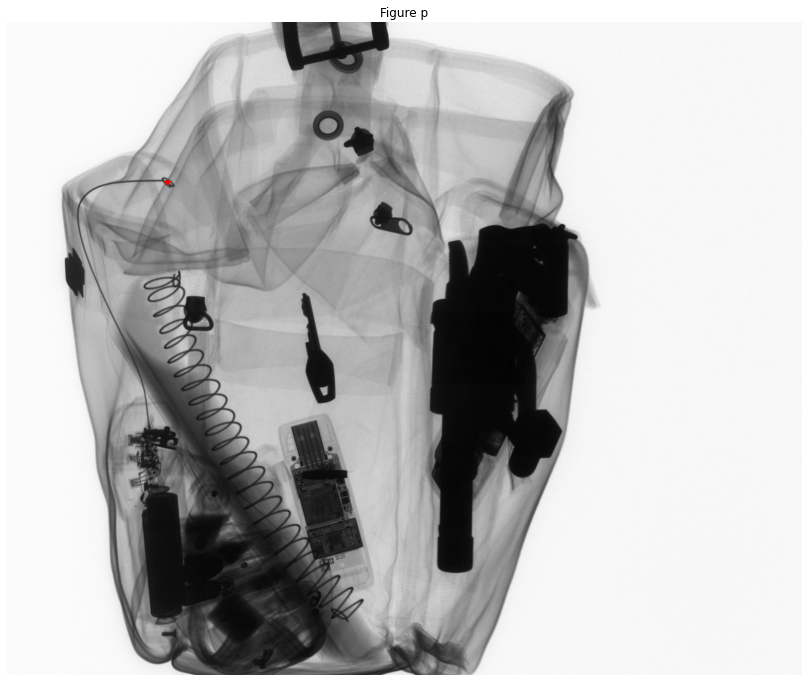

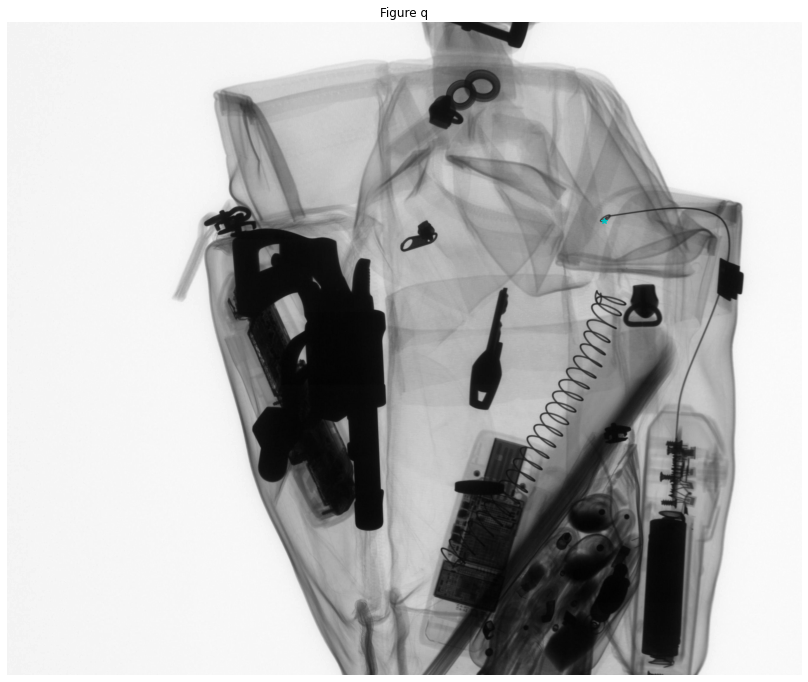

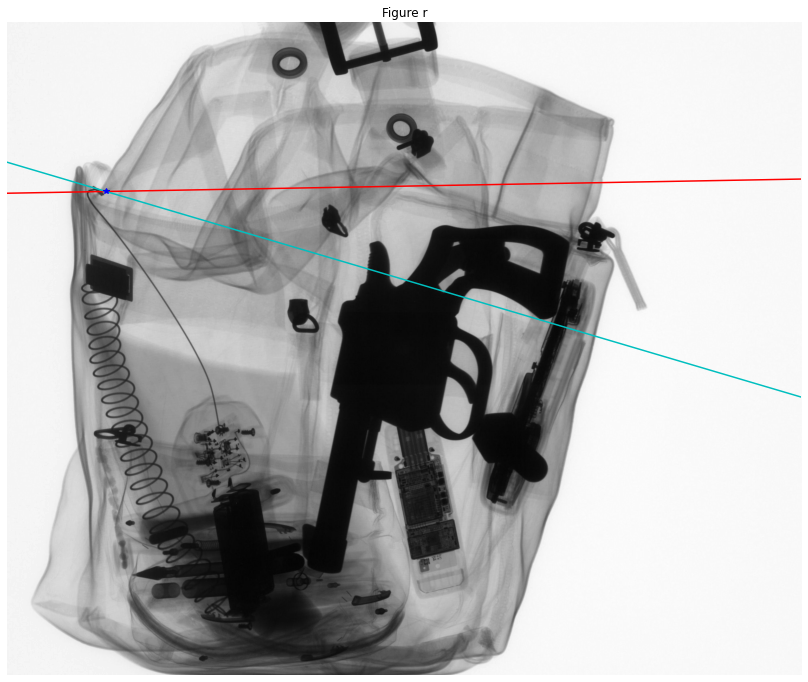

In [ ]:
import numpy as np
import matplotlib.pylab as plt
from cv2 import imread, IMREAD_GRAYSCALE


p, q, r = (1, 90, 170)  # Indices for p, q, and r

# Load projection matrices for views p, q, r
P1 = data['P'][:, :, p]  # Reprojection matrix of view p
P2 = data['P'][:, :, q]  # Reprojection matrix of view q
P3 = data['P'][:, :, r]

print('Projection Matrices:')
print('P1 = ',P1)
print('P2 = ',P2)
print('P3 = ',P3)

Ip = imread('B0044/B0044_'+num2fixstr(p,4)+'.png', IMREAD_GRAYSCALE)
Iq = imread('B0044/B0044_'+num2fixstr(q,4)+'.png', IMREAD_GRAYSCALE)
Ir = imread('B0044/B0044_'+num2fixstr(r,4)+'.png', IMREAD_GRAYSCALE)


F13 = estimate_fundamental_matrix(P1, P3, method='pseudo')
F23 = estimate_fundamental_matrix(P2, P3, method='pseudo')



# Plot lines and plot on figures
#print('Click a point in Figure 1 ...')
fig1, ax1 = plt.subplots(1, 1, subplot_kw=dict(title='Figure p'),figsize=(18,12))
ax1.imshow(Ip, cmap='gray')
ax1.axis('off')

#mp = np.hstack([np.array(plt.ginput(1)), np.ones((1, 1))]).T  # Click

# clicked pixel in image 'p'
mp = np.ones((3,1))
mp[0] = 542
mp[1] = 539

ax1.plot(mp[0], mp[1], 'r*')
fig1.canvas.draw()

#print('Click a point in Figure 2 ...')
fig2, ax2 = plt.subplots(1, 1, subplot_kw=dict(title='Figure q'),figsize=(18,12))
ax2.imshow(Iq, cmap='gray')
ax2.axis('off')

#mq = np.hstack([np.array(plt.ginput(1)), np.ones((1, 1))]).T  # Click
# clicked pixel in image 'q'
mq = np.ones((3,1))
mq[0] = 2020
mq[1] = 672


ax2.plot(mq[0], mq[1], 'c*')
fig2.canvas.draw()

# Epipolar lines
ell_13 = np.dot(F13,mp) 
ell_23 = np.dot(F23,mq)

# Intersection of epipolar lines
mr     = np.cross(ell_13.T,ell_23.T)
mr     = mr.T
mr     = mr/mr[-1]

fig3, ax3 = plt.subplots(1, 1, subplot_kw=dict(title='Figure r'),figsize=(18,12))
ax3.imshow(Ir, cmap='gray')
ax3.axis('off')

ax3 = plot_epipolar_line(F13, mp, line_color=colors[0], ax=ax3)
ax3 = plot_epipolar_line(F23, mq, line_color=colors[1], ax=ax3)
ax3.plot(mr[0, 0], mr[1, 0], 'b*')
fig3.canvas.draw()

plt.show()

# Trifocal Geometry

See example in [Colab](https://colab.research.google.com/drive/1eP_ru4yKl9yqI9t1BUwl5Rj5suWEc2Br?usp=sharing)